# MAHTS generation

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import measure
from skimage.morphology import disk
from skimage.morphology import square
from skimage.morphology import binary_dilation
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import map_shapefile
from dea_plotting import display_map
from dea_spatialtools import interpolate_2d
from dea_spatialtools import subpixel_contours
from dea_spatialtools import largest_region


def interpolate_tide(timestep_ds, tidepoints_gdf, method='rbf', factor=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''
    
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:10]
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              method=method,
                              factor=factor)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def tidal_composite(year_ds, tide_cutoff, output_dir, export_geotiff=False):
    '''
    Loads data for a time period into memory, masks to keep only
    pixels observed at > median tide, takes median and counts of valid 
    water index results, and optionally writes each water index, tide 
    height and valid pixel counts for the time period to file
    '''
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}')
    
    # Load in data for year and mask to keep above median tide pixels
    year_ds = year_ds.compute()
    year_ds = year_ds.where(year_ds.tide_m >= tide_cutoff)
    
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    median_ds['stdev'] = year_ds.mndwi.std(dim='time', keep_attrs=True)
    
    # Write each variable to file
    if export_geotiff:
        for i in median_ds:
            write_geotiff(filename=f'{output_dir}/{i}_{str(year)}.tif', 
                          dataset=median_ds[[i]])
        
    return median_ds


def mask_ocean(bool_array, **kwargs):
    '''
    Identifies ocean by selecting the largest connected area of water
    pixels, then dilating this region by 1 pixel to include mixed pixels
    '''
    
    ocean_mask = largest_region(bool_array, **kwargs)
    ocean_mask = binary_dilation(ocean_mask, 
                                 selem=square(3))

    return ocean_mask


# This will speed up loading data
import datacube.utils.rio
# datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)
datacube.utils.rio.configure_s3_access(aws_unsigned=True)

### Set up Dask

In [2]:
# from datacube.utils.dask import start_local_dask
# from datacube.utils.rio import configure_s3_access
# import dask
# import os

# dask.config.set({"distributed.dashboard.link": 
#         os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"})

# client = start_local_dask(threads_per_worker=8, memory_limit='8G')
# display(client)

# creds = configure_s3_access(client=client, 
#                             region_name='auto')

### Connect to the datacube

In [3]:
# dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [4]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [5]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

In [6]:
name = 'stradbroke
query = {'x': (153.42, 153.61),
         'y': (-27.35, -28.4919),
         'time': ('1987', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80],
        }

# Gold Coast
name = 'brisbane'
query = {'x': (153.00, 153.50),
         'y': (-26.6499,  -27.6495),
         'time': ('1987', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80],
        }


name = 'fraser'
query = {'x': (152.9819, 153.20),
         'y': (-25.60,  -26.67),
         'time': ('1987', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80],
        }


name = 'yamba'
query = {'x': (153.29,  153.4735  ),
         'y': (-29.0994,  -29.7381),
         'time': ('1987', '2018'),
         'dask_chunks': {'time': 1},
         'cloud_cover': [0, 80],
        }

    
# name = 'byron'
# query = {'x': (153.42, 153.645),
#          'y': (-28.46, -29.17),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'x': 800, 'y': 800},
#          'cloud_cover': [0, 80]}


# # Moreton Bay
# name = 'moretonbay'
# query = {'x': (153.00, 153.25),
#          'y': (-26.81, -27.44),
#          'time': ('2008', '2008'),
#          'cloud_cover': [0, 80]}

# # Moreton Bay seam test
# name = 'moretonbay'
# query = {'x': (153.10, 153.18),
#          'y': (-26.70, -26.83),
#          'time': ('2000', '2010'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Moreton Bay small
# name = 'moretonbay'
# query = {'x': (153.16, 153.2840),
#          'y': (-27.315, -27.4416),
#          'time': ('2000', '2010'),
# #          'output_crs': 'EPSG:32756',
# #          'resolution': (-30, 30),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Fremantle
# name = 'fremantle'
# query = {'x': (115.70,  115.81),
#          'y': (-31.94, -32.08),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}


# Preview study area
display_map(x=query['x'], y=query['y'])

## Load virtual product

In [7]:
# product = catalog['ls_nbart_indices']
# ds = product.load(dc, **query)
# ds

from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

ds = load_ard(dc=dc, 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.0,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              output_crs='epsg:32756',
              resampling={'*': 'average', 'fmask': 'nearest', 'oa_fmask': 'nearest'},
              resolution=(-30, 30),  
              gqa_iterative_mean_xy=[0, 1],
              align=(15, 15),
              lazy_load=True,
              group_by='solar_day',
              **query)

ds = (calculate_indices(ds, index=['NDWI', 'MNDWI', 'AWEI_ns', 'AWEI_sh'], 
                        collection='ga_ls_3', 
                        drop=True)
      .rename({'NDWI': 'ndwi', 'MNDWI': 'mndwi', 'AWEI_ns': 'awei_ns', 'AWEI_sh': 'awei_sh'}))

Loading ga_ls5t_ard_3 data
    329 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    352 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    106 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 787 observations as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


In [8]:
# ds.awei_ns.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Model tides

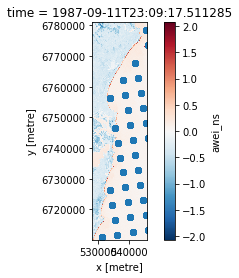

In [9]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.07).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=1).awei_ns.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [10]:
# Interpolate tides for each timestep into the spatial extent of the data
tide_da = ds.groupby('time').apply(interpolate_tide, 
                                   tidepoints_gdf=tidepoints_gdf)

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add interpolated tides as measurement in satellite dataset
ds['tide_m'] = tide_da

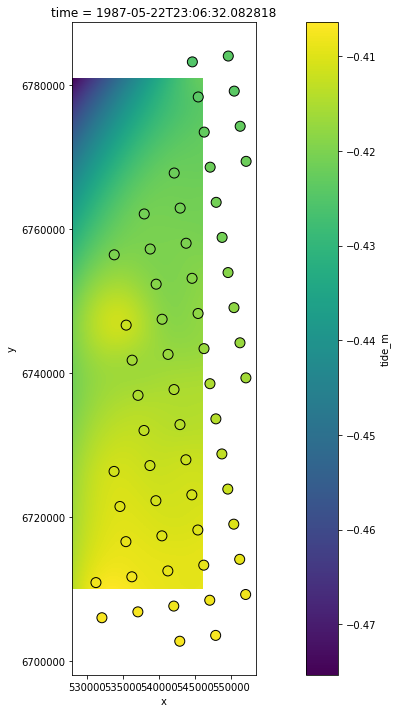

In [11]:
# Plot 
ds_i = ds['tide_m'].isel(time=0)
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(), 
                                                     vmax=ds_i.max().item())

## Generate yearly composites

In [12]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{name}'
os.makedirs(output_dir, exist_ok=True)

# Generate yearly high tide median water indices
yearly_ds = ds.groupby('time.year').apply(tidal_composite, 
                                          tide_cutoff=tide_cutoff, 
                                          output_dir=output_dir,
                                          export_geotiff=True)


Processing 1987
Processing 1988
Processing 1989
Processing 1990
Processing 1991
Processing 1992
Processing 1993
Processing 1994
Processing 1995
Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


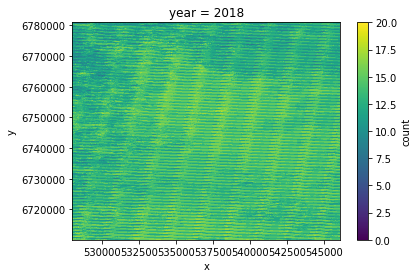

In [13]:
# Plot
yearly_ds['count'].isel(year=-1).plot(vmin=0, vmax=20)

## Extract shoreline contours

### Extract ocean-masked contours

Operating in single z-value, multiple arrays mode
Writing contours to output_data/yamba/contours_mndwi_0.00.geojson


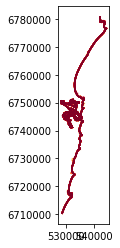

In [14]:
# Set parameters
water_index = 'mndwi'
index_threshold = 0.0

# Apply index and threshold
thresholded_ds = (yearly_ds[water_index] > index_threshold)

# Drop empty timesteps
thresholded_ds = (thresholded_ds
                  .sel(year=thresholded_ds.sum(dim=['x', 'y']) > 0))

# Generate all time 600 m buffer from ocean
from skimage.morphology import binary_opening
from skimage.morphology import binary_erosion
full_sea_mask = mask_ocean(binary_opening(thresholded_ds.median(dim='year'), 
                                          disk(3)))
buffer_ocean = binary_dilation(full_sea_mask, disk(20))
buffer_land = binary_dilation(~full_sea_mask, disk(20))
sea_buffer = buffer_ocean & buffer_land

# Generate sea mask for each timestep
yearly_sea_mask = thresholded_ds.groupby('year').apply(mask_ocean)

# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
masked_ds = yearly_ds[water_index].where(yearly_sea_mask & sea_buffer)

# Set CRS from input data
masked_ds.attrs['crs'] = ds.crs

# Extract contours
output_path = f'{output_dir}/contours_{water_index}_{index_threshold:.2f}'
contours_gdf = subpixel_contours(da=masked_ds,
                                 z_values=index_threshold,
                                 output_path=f'{output_path}.geojson',
                                 dim='year')

# Plot
# map_shapefile(gdf=contours_gdf, hover_col='year')
contours_gdf.plot(column='year', cmap='YlOrRd')

### Extract cleaned contours

In [15]:
# Keep only pixels that are within 600 m of the ocean in the
# full stack, and directly connected to ocean in each yearly timestep
cleaned_ds = masked_ds.where((yearly_ds['count'] >= 5) & (yearly_ds['stdev'] < 0.5))

# Extract contours
output_path = f'{output_dir}/contours_{water_index}_{index_threshold:.2f}'
contours_gdf = subpixel_contours(da=cleaned_ds,
                                 z_values=index_threshold,
                                 output_path=f'{output_path}_cleaned.geojson',
                                 dim='year')

Operating in single z-value, multiple arrays mode
Failed to generate contours: 1987
Writing contours to output_data/yamba/contours_mndwi_0.00_cleaned.geojson


In [29]:
ds.isel(time=[0, -1]).time.values

array(['1987-05-22T23:06:32.082818000', '2018-12-29T23:37:48.826669000'],
      dtype='datetime64[ns]')

In [16]:
# Plot
# map_shapefile(gdf=contours_gdf, hover_col='year')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.7+128.gebdc898a.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)